# SeaAlert Baselines - Technical Explanation (Professional)




## Block 1 - Imports + Seed
- Loads libraries for data handling, plotting, classical ML (scikit-learn), and Transformers (HF + torch).
- Sets `RANDOM_SEED` to keep splits and model behavior reproducible.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

pd.set_option("display.max_colwidth", 160)
pd.set_option("display.max_columns", 50)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Block 2 - Load Data + Basic Validation
- Loads CSV into `df`.
- Validates required columns (`text`, `label`) exist.
- Creates `text_str` to enforce consistent string input for all later steps.


In [3]:
from google.colab import drive


In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
%cd "/content/drive/Othercomputers/ה-Mac שלי/SeaAlert"
DATA_PATH = "data/subset_300/SeaAlert_300samples.csv"


df = pd.read_csv(DATA_PATH)


/content/drive/Othercomputers/ה-Mac שלי/SeaAlert


In [6]:
print(f"DF shape: {df.shape}\n")

display(df[['text','label','has_codeword']].head(3))

assert "text" in df.columns and "label" in df.columns, "df must contain 'text' and 'label'"

df['text_str'] = df['text'].astype(str)




DF shape: (300, 13)



,text,label,has_codeword
0,"Uh, station listening, we’re at 5 nm west of Haifa… call sign 4XAB1, MMSI 653035110. Just giving our position report, please confirm you copy.",Routine,False
1,"Eilat Marina, anyone on VHF copy? This is call sign 4XCD2, just doing a radio check, can you hear me?",Routine,False
2,"RELAY, RELAY, RELAY. RECEIVED FROM SEA BREEZE. SEA BREEZE, call sign 4XCD2, MMSI 653778756, REPORTING POSITION AT Hadera power station area. WEATHER HEAVY R...",Routine,False


## Block 3 - Codeword Extraction + Masking
- `extract_codeword`: detects `MAYDAY`, `PAN PAN` (incl. variants), `SECURITE`; otherwise returns `NONE`.
- `CODEWORD_PATTERN` + `mask_codewords`: replaces any detected codeword with `[CODEWORD]` to test shortcut reliance.
- Adds:
  - `actual_codeword` (for slicing evaluation subsets)
  - `text_masked` (for masked-input robustness tests)


In [7]:
def extract_codeword(text :str) -> str:
    t = str(text).upper()
    if "MAYDAY" in t:
        return "MAYDAY"
    if "PAN PAN" in t or "PAN-PAN" in t or "PANPAN" in t:
        return "PAN PAN"
    if "SECURITE" in t or "SÉCURITÉ" in t:
        return "SECURITE"
    return "NONE"

CODEWORD_PATTERN = re.compile(
    r"\b(MAYDAY|PAN\s*PAN|PAN-PAN|PANPAN|SECURITE|SÉCURITÉ)\b",
    flags=re.IGNORECASE
)

def mask_codewords(text: str, token: str = "[CODEWORD]") -> str:
  return CODEWORD_PATTERN.sub(token, str(text))

df["actual_codeword"] = df["text_str"].apply(extract_codeword)
df["text_masked"] = df["text_str"].apply(mask_codewords)

LABELS_ORDER = ["Routine", "Safety", "Urgency", "Distress"]


## Block 4 - Stratified Split + Subsets
- Splits into train/test with `stratify=y` to preserve class balance.
- Keeps `idx_train/idx_test` to rebuild `test_df` with full metadata.
- Builds evaluation slices:
  - Full test: `X_test`, `y_test`
  - Hard subset (no codeword): `X_test_none`, `y_test_none` where `actual_codeword == "NONE"`
  - Masked inputs: `X_train_masked`, `X_test_masked`
  - Masked hard subset: `X_test_none_masked` (typically identical to `X_test_none` content-wise)


In [8]:
X = df['text_str']
y = df['label']

X_train,X_test,y_train,y_test,idx_train,idx_test = train_test_split(
    X,
    y,
    df.index,
    test_size = 0.2,
    random_state= RANDOM_SEED,
    stratify = y,
)

test_df = df.loc[idx_test].copy()
print("\nShape of test_df:",test_df.shape)
print("\nColumns of test_df:",test_df.columns.tolist())


none_mask_test = test_df["actual_codeword"] == "NONE"

X_test_none = test_df.loc[none_mask_test, "text_str"]
y_test_none = test_df.loc[none_mask_test, "label"]

X_train_masked = df.loc[idx_train, "text_masked"]
X_test_masked  = df.loc[idx_test,  "text_masked"]

X_test_none_masked = test_df.loc[none_mask_test, "text_masked"]

print("\nTrain:", len(X_train), "Test:", len(X_test))
print("\nNONE-only in test:", len(X_test_none))



Shape of test_df: (60, 16)

Columns of test_df: ['label', 'scenario_type', 'style', 'vessel', 'call_sign', 'mmsi', 'location', 'weather', 'pob', 'has_codeword', 'codeword_type', 'codeword', 'text', 'text_str', 'actual_codeword', 'text_masked']

Train: 240 Test: 60

NONE-only in test: 31


## Block 5 - Evaluation Helpers
- `plot_confusion`: confusion matrix heatmap with a fixed `LABELS_ORDER` for consistent class ordering.
- `evaluate_predictions`: prints Accuracy + Macro-F1, optional per-class report, then plots confusion matrix.
- `results`: list used to collect metrics for final comparison plots.


In [9]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=LABELS_ORDER)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABELS_ORDER, yticklabels=LABELS_ORDER)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


def evaluate_predictions(name, y_true, y_pred, show_report=True):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"\n{name}")
    print("Accuracy:", round(acc, 4))
    print("Macro-F1:", round(f1m, 4))

    if show_report:
        print("\nClassification report:")
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        display(report_df)

    plot_confusion(y_true, y_pred, f"Confusion Matrix - {name}")
    return acc, f1m

results = []


## Block 6 - Model A (TF-IDF + Logistic Regression)
- Pipeline:
  - TF-IDF (uni+bi-grams) transforms text into sparse features.
  - Logistic Regression learns a linear classifier.
- Evaluations (same trained model):
  - Full test
  - NONE-only test
  - Full test with masked input
  - NONE-only with masked input
- Error table (NONE-only) helps inspect typical failure cases.



Model A (BoW TF-IDF + LR) - Full test
Accuracy: 0.9167
Macro-F1: 0.9187

Classification report:


,precision,recall,f1-score,support
Distress,1.000000,0.800000,0.888889,15.000000
Routine,0.750000,1.000000,0.857143,15.000000
Safety,1.000000,1.000000,1.000000,15.000000
Urgency,1.000000,0.866667,0.928571,15.000000
accuracy,0.916667,0.916667,0.916667,0.916667
macro avg,0.937500,0.916667,0.918651,60.000000
weighted avg,0.937500,0.916667,0.918651,60.000000


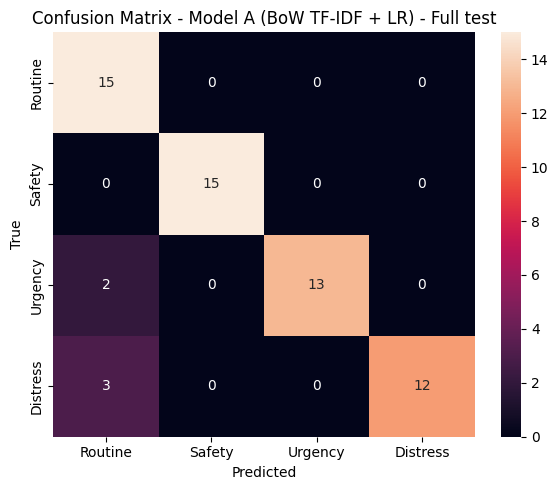


Model A (BoW TF-IDF + LR) - NONE-only test
Accuracy: 0.8387
Macro-F1: 0.8185

Classification report:


,precision,recall,f1-score,support
Distress,1.000000,0.50000,0.666667,6.00000
Routine,0.750000,1.00000,0.857143,15.00000
Safety,1.000000,1.00000,1.000000,5.00000
Urgency,1.000000,0.60000,0.750000,5.00000
accuracy,0.838710,0.83871,0.838710,0.83871
macro avg,0.937500,0.77500,0.818452,31.00000
weighted avg,0.879032,0.83871,0.826037,31.00000


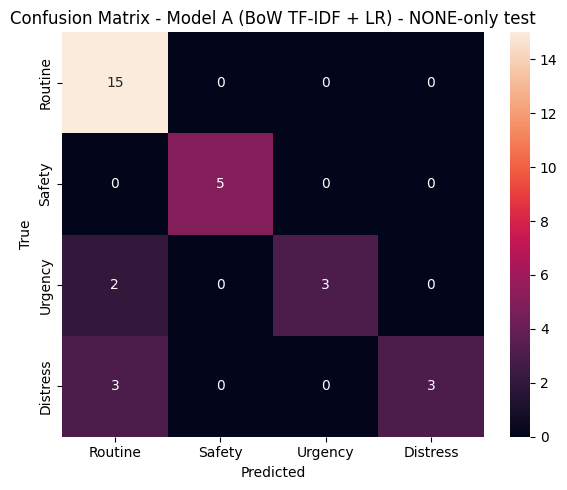


Model A (BoW TF-IDF + LR) - Full test (masked input)
Accuracy: 0.7333
Macro-F1: 0.703

Classification report:


,precision,recall,f1-score,support
Distress,0.750000,0.800000,0.774194,15.000000
Routine,0.600000,1.000000,0.750000,15.000000
Safety,0.866667,0.866667,0.866667,15.000000
Urgency,1.000000,0.266667,0.421053,15.000000
accuracy,0.733333,0.733333,0.733333,0.733333
macro avg,0.804167,0.733333,0.702978,60.000000
weighted avg,0.804167,0.733333,0.702978,60.000000


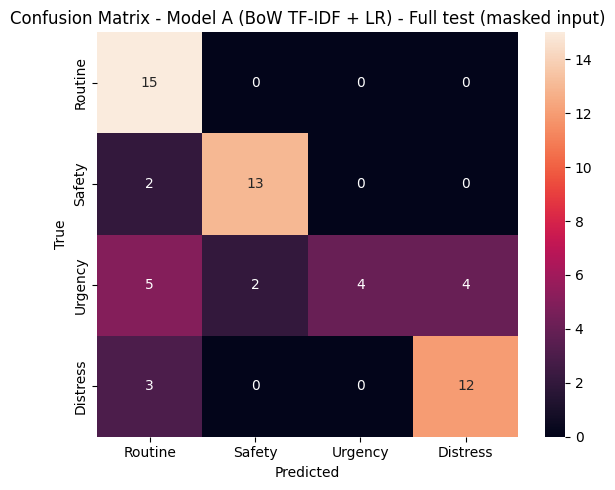


Model A (BoW TF-IDF + LR) - NONE-only (masked input)
Accuracy: 0.8387
Macro-F1: 0.8185

Classification report:


,precision,recall,f1-score,support
Distress,1.000000,0.50000,0.666667,6.00000
Routine,0.750000,1.00000,0.857143,15.00000
Safety,1.000000,1.00000,1.000000,5.00000
Urgency,1.000000,0.60000,0.750000,5.00000
accuracy,0.838710,0.83871,0.838710,0.83871
macro avg,0.937500,0.77500,0.818452,31.00000
weighted avg,0.879032,0.83871,0.826037,31.00000


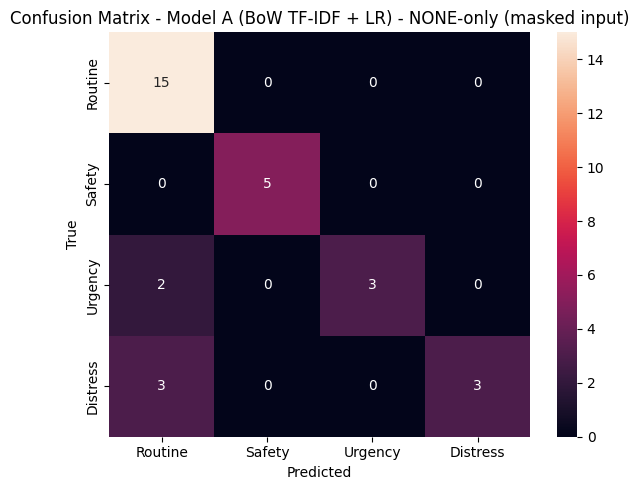


Model A - NONE-only errors: 5


,label,style,actual_codeword,text_str,pred
246,Distress,third_party,NONE,"RELAY, RELAY, RELAY. RECEIVED FROM COASTAL SPIRIT, CALL SIGN 4XEF3, MMSI 326074193. PERSON OVERBOARD REPORTED. POSITION: Hadera power station area. WEATHER:...",Routine
201,Urgency,third_party,NONE,"RELAY, RELAY, RELAY. RECEIVED DISTRESS CALL FROM MEDITERRANEAN DREAM, CALL SIGN 4XJK5, MMSI 641087900. REPORTING ENGINE FAILURE AT POSITION Ashdod Port. WEA...",Routine
262,Distress,third_party,NONE,"RELAY, RELAY, RELAY. RECEIVED DISTRESS CALL FROM BLUE HORIZON, CALL SIGN 4XGH4, MMSI 522660441. REPORTING FIRE ON BOARD. POSITION 5 nm west of Haifa. WEATHE...",Routine
191,Urgency,third_party,NONE,"RELAY, RELAY, RELAY\n\nRECEIVED FROM MEDITERRANEAN DREAM, CALL SIGN 4XEF3, MMSI 680101819. REPORTING A MEDICAL ISSUE ON BOARD. POSITION Palmahim Beach. WEA...",Routine
285,Distress,third_party,NONE,"RELAY, RELAY, RELAY. RECEIVED DISTRESS CALL FROM RED SEA RUNNER. Vessel RED SEA RUNNER, call sign 4XGH4, MMSI 491086098, reporting fire onboard at Ashdod Po...",Routine


In [10]:
# ============================================================
# MODEL A: TF-IDF + Logistic Regression
# ============================================================


bow_lr = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.95)),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
])
bow_lr.fit(X_train, y_train)

pred_full = bow_lr.predict(X_test)
acc, f1m = evaluate_predictions("Model A (BoW TF-IDF + LR) - Full test", y_test, pred_full)
results.append({"model": "BoW+LR", "setting": "Full", "accuracy": acc, "macro_f1": f1m})

# NONE-only test
if len(X_test_none) > 0:
    pred_none = bow_lr.predict(X_test_none)
    acc, f1m = evaluate_predictions("Model A (BoW TF-IDF + LR) - NONE-only test", y_test_none, pred_none)
    results.append({"model": "BoW+LR", "setting": "NONE-only", "accuracy": acc, "macro_f1": f1m})

# Masked-codewords test (same trained model, but input has [CODEWORD])
pred_full_masked = bow_lr.predict(X_test_masked)
acc, f1m = evaluate_predictions("Model A (BoW TF-IDF + LR) - Full test (masked input)", y_test, pred_full_masked)
results.append({"model": "BoW+LR", "setting": "Full (masked input)", "accuracy": acc, "macro_f1": f1m})

if len(X_test_none_masked) > 0:
    pred_none_masked = bow_lr.predict(X_test_none_masked)
    acc, f1m = evaluate_predictions("Model A (BoW TF-IDF + LR) - NONE-only (masked input)", y_test_none, pred_none_masked)
    results.append({"model": "BoW+LR", "setting": "NONE-only (masked input)", "accuracy": acc, "macro_f1": f1m})

# Simple error table (NONE-only)
if len(X_test_none) > 0:
    err_idx = X_test_none.index[pred_none != y_test_none.values]
    print("\nModel A - NONE-only errors:", len(err_idx))
    if len(err_idx) > 0:
        err_df = test_df.loc[err_idx, ["label", "style", "actual_codeword", "text_str"]].copy()
        err_df["pred"] = pred_none[pred_none != y_test_none.values]
        display(err_df.head(10))


## Block 7 - Model B (DistilBERT Fine-Tuning)
- Creates `label2id/id2label` mappings for Transformers.
- Converts splits to HF `Dataset`, tokenizes with truncation + padding.
- Fine-tunes DistilBERT using `Trainer` and reports Accuracy + Macro-F1.
- Evaluates:
  - Full test
  - NONE-only test
  - Full test with masked input (no retraining)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]


Device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4048334393.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.222000,1.106781,0.800000,0.809461
2,0.523300,0.584657,0.850000,0.853130
3,0.315700,0.403036,0.850000,0.851154
4,0.105200,0.321931,0.883333,0.882703
5,0.042600,0.248504,0.900000,0.899770
6,0.025700,0.296206,0.916667,0.916369
7,0.015500,0.301219,0.916667,0.916369
8,0.012900,0.303485,0.916667,0.916369
9,0.009800,0.313421,0.916667,0.916369
10,0.008700,0.318603,0.916667,0.916369



Model B (DistilBERT) - Full test
Accuracy: 0.9167
Macro-F1: 0.9164

Classification report:


,precision,recall,f1-score,support
Distress,0.933333,0.933333,0.933333,15.000000
Routine,0.923077,0.800000,0.857143,15.000000
Safety,1.000000,1.000000,1.000000,15.000000
Urgency,0.823529,0.933333,0.875000,15.000000
accuracy,0.916667,0.916667,0.916667,0.916667
macro avg,0.919985,0.916667,0.916369,60.000000
weighted avg,0.919985,0.916667,0.916369,60.000000


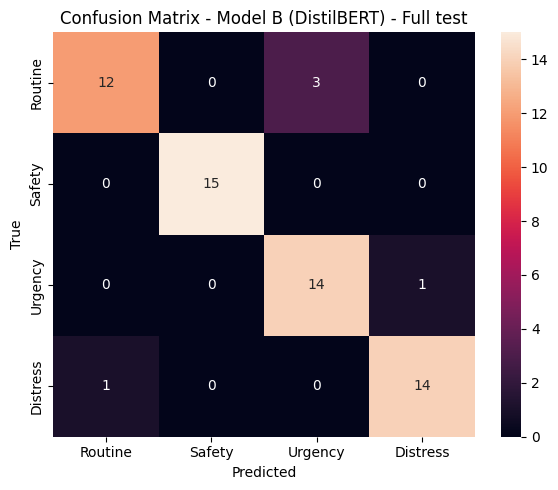


Model B (DistilBERT) - NONE-only test
Accuracy: 0.8387
Macro-F1: 0.8393

Classification report:


,precision,recall,f1-score,support
Distress,0.833333,0.833333,0.833333,6.00000
Routine,0.923077,0.800000,0.857143,15.00000
Safety,1.000000,1.000000,1.000000,5.00000
Urgency,0.571429,0.800000,0.666667,5.00000
accuracy,0.838710,0.838710,0.838710,0.83871
macro avg,0.831960,0.858333,0.839286,31.00000
weighted avg,0.861397,0.838710,0.844854,31.00000


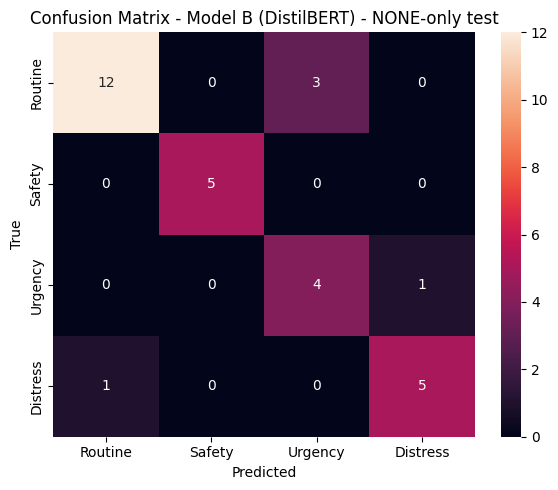

Map:   0%|          | 0/60 [00:00<?, ? examples/s]


Model B (DistilBERT) - Full test (masked input)
Accuracy: 0.8333
Macro-F1: 0.8321

Classification report:


,precision,recall,f1-score,support
Distress,0.736842,0.933333,0.823529,15.000000
Routine,0.923077,0.800000,0.857143,15.000000
Safety,0.933333,0.933333,0.933333,15.000000
Urgency,0.769231,0.666667,0.714286,15.000000
accuracy,0.833333,0.833333,0.833333,0.833333
macro avg,0.840621,0.833333,0.832073,60.000000
weighted avg,0.840621,0.833333,0.832073,60.000000


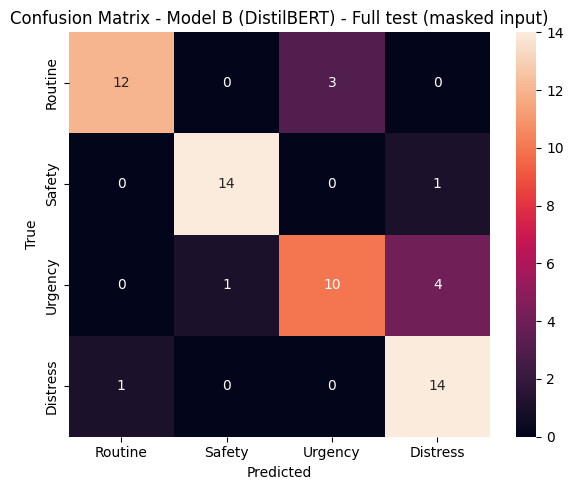

In [11]:
# ============================================================
# MODEL B: DistilBERT fine-tuning (Transformers Trainer)
# ============================================================
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

MODEL_NAME = "distilbert-base-uncased"

# Label mapping
label2id = {lbl: i for i, lbl in enumerate(LABELS_ORDER)}
id2label = {i: lbl for lbl, i in label2id.items()}

def make_hf_dataset(text_series, label_series):
    tmp = pd.DataFrame({
        "text": text_series.values,
        "label": [label2id[x] for x in label_series.values]
    })
    return Dataset.from_pandas(tmp, preserve_index=False)

train_ds = make_hf_dataset(X_train, y_train)
test_ds  = make_hf_dataset(X_test,  y_test)

# NONE-only test dataset
if len(X_test_none) > 0:
    test_none_ds = make_hf_dataset(X_test_none, y_test_none)
else:
    test_none_ds = None

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)
if test_none_ds is not None:
    test_none_ds = test_none_ds.map(tokenize, batched=True)

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
if test_none_ds is not None:
    test_none_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("\nDevice:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABELS_ORDER),
    id2label=id2label,
    label2id=label2id
).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": f1m}

training_args = TrainingArguments(
    output_dir="./seaalert_distilbert_out",
    seed=RANDOM_SEED,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# Predictions - Full test
pred = trainer.predict(test_ds)
pred_ids = np.argmax(pred.predictions, axis=1)
true_ids = pred.label_ids

y_pred_labels = [id2label[i] for i in pred_ids]
y_true_labels = [id2label[i] for i in true_ids]

acc, f1m = evaluate_predictions("Model B (DistilBERT) - Full test", y_true_labels, y_pred_labels)
results.append({"model": "DistilBERT", "setting": "Full", "accuracy": acc, "macro_f1": f1m})

# Predictions - NONE-only test
if test_none_ds is not None and len(test_none_ds) > 0:
    pred_none_b = trainer.predict(test_none_ds)
    pred_none_ids = np.argmax(pred_none_b.predictions, axis=1)
    true_none_ids = pred_none_b.label_ids

    y_pred_none_labels = [id2label[i] for i in pred_none_ids]
    y_true_none_labels = [id2label[i] for i in true_none_ids]

    acc, f1m = evaluate_predictions("Model B (DistilBERT) - NONE-only test", y_true_none_labels, y_pred_none_labels)
    results.append({"model": "DistilBERT", "setting": "NONE-only", "accuracy": acc, "macro_f1": f1m})

# Masked input evaluation for DistilBERT (no retrain, just test masked)
test_masked_df = pd.DataFrame({
    "text": X_test_masked.values,
    "label": [label2id[x] for x in y_test.values]
})
test_masked_ds = Dataset.from_pandas(test_masked_df, preserve_index=False).map(tokenize, batched=True)
test_masked_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

pred_masked_b = trainer.predict(test_masked_ds)
pred_masked_ids = np.argmax(pred_masked_b.predictions, axis=1)
true_masked_ids = pred_masked_b.label_ids

y_pred_masked_labels = [id2label[i] for i in pred_masked_ids]
y_true_masked_labels = [id2label[i] for i in true_masked_ids]

acc, f1m = evaluate_predictions("Model B (DistilBERT) - Full test (masked input)", y_true_masked_labels, y_pred_masked_labels)
results.append({"model": "DistilBERT", "setting": "Full (masked input)", "accuracy": acc, "macro_f1": f1m})

## Block 8 - Results Table + Comparison Plots
- Aggregates all runs into `res_df` (Accuracy + Macro-F1 per model/setting).
- Bar plots compare models across:
  - Full vs NONE-only
  - Original vs masked input
- Main signal: masking drop indicates shortcut reliance; NONE-only reflects semantic understanding.







Final Comparative Results:


,model,setting,accuracy,macro_f1
0,BoW+LR,Full,0.9167,0.9187
4,DistilBERT,Full,0.9167,0.9164
1,BoW+LR,NONE-only,0.8387,0.8185
5,DistilBERT,NONE-only,0.8387,0.8393
2,BoW+LR,Full (masked input),0.7333,0.7030
6,DistilBERT,Full (masked input),0.8333,0.8321


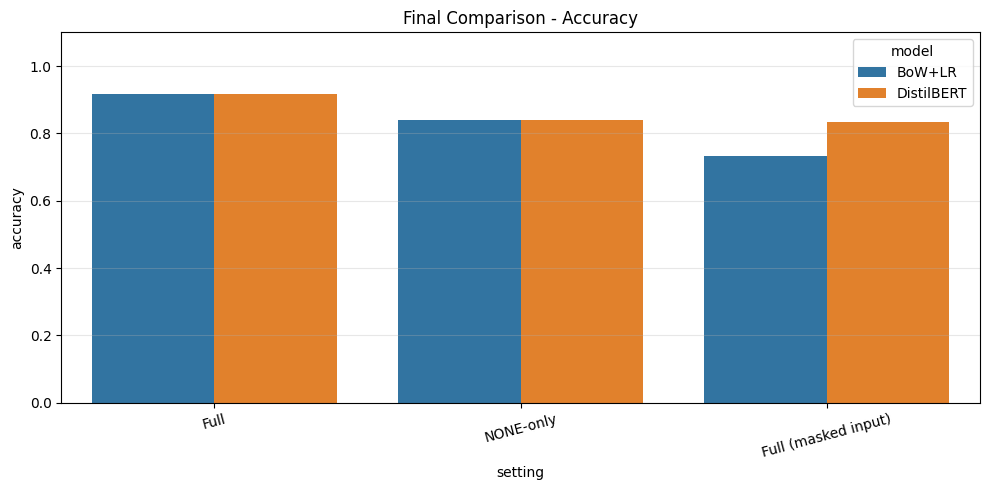

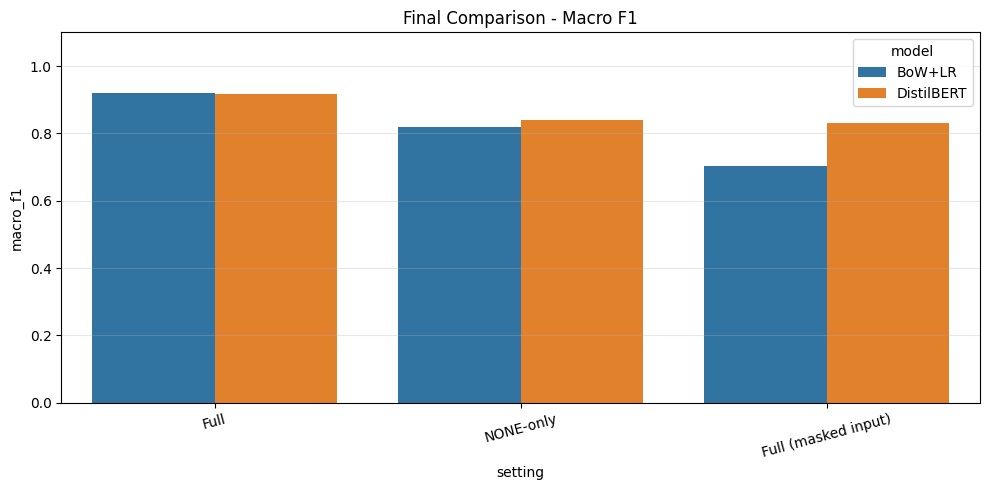

In [ ]:
# ----------------------------
# 5) Visual comparison table + bar plots
# ----------------------------
res_df = pd.DataFrame(results)

keep_settings = ["Full", "NONE-only", "Full (masked input)"]
res_df = res_df[res_df["setting"].isin(keep_settings)].copy()


res_df["setting"] = pd.Categorical(res_df["setting"], categories=keep_settings, ordered=True)
res_df = res_df.sort_values(["setting", "model"])

# rounding
res_df["accuracy"]  = res_df["accuracy"].round(4)
res_df["macro_f1"]  = res_df["macro_f1"].round(4)

print("Final Comparative Results:")
display(res_df)

# Plot Accuracy
plt.figure(figsize=(10, 5))
sns.barplot(data=res_df, x="setting", y="accuracy", hue="model")
plt.title("Final Comparison - Accuracy")
plt.xticks(rotation=15)
plt.ylim(0, 1.1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Macro F1
plt.figure(figsize=(10, 5))
sns.barplot(data=res_df, x="setting", y="macro_f1", hue="model")
plt.title("Final Comparison - Macro F1")
plt.xticks(rotation=15)
plt.ylim(0, 1.1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
